In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import os 
from glob import glob 
import numpy as np
import pandas as pd
#!conda activate delta_env
import scipy
import skimage
from skimage.data import page
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)
from skimage.filters import threshold_otsu, threshold_local, rank
import tqdm as tqdm
from skimage import measure
from skimage.morphology import square,erosion,disk
from skimage.exposure import rescale_intensity
import seaborn as sns
from tqdm import tqdm
import scipy.ndimage as ndimage 
from skimage.morphology import convex_hull_image as convexhull
from skimage.morphology import erosion, dilation, opening, closing
import warnings
warnings.filterwarnings("ignore")

from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)

C:\ProgramData\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
files = []
files_tifgfp = []

root='./'
fluor_dir = './Images/Gray' 

pattern_tif='*.tif'


for dir,_,_ in os.walk(fluor_dir):
    files.extend(glob(os.path.join(dir,pattern_tif)))
i=1

mask_dir='./manualtracking'

filesmask=[]
for dir,_,_ in os.walk(mask_dir):
    filesmask.extend(glob(os.path.join(dir,pattern_tif)))
i=1


In [33]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def colorhtml(i):
    j=i%9
    colors=['#E91E63','#9C27B0','#3F51B5','#03A9F4','#00BCD4','#009688','#8BC34A','#FFEB3B','#FF9800','#FF5722']
    return colors[j]
#props2 = dict(boxstyle='round',facecolor= '#FFFFFF',linewidth=1,edgecolor='#AEAEAE')

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0, 0, N)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.linspace(0, 0, N)
greencmp = ListedColormap(vals)

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0, 1, N)
vals[:, 1] = np.linspace(0, 0, N)
vals[:, 2] = np.linspace(0, 0, N)
redcmp = ListedColormap(vals)


N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0, 0, N)
vals[:, 1] = np.linspace(0, 0, N)
vals[:, 2] = np.linspace(0, 1, N)
bluecmp = ListedColormap(vals)

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0, 1, N)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.linspace(0, 1, N)
whitecmp = ListedColormap(vals)

In [44]:
from tqdm import tqdm

In [ ]:
if not os.path.exists('./figures'):
    os.makedirs('./figures') #Figures path
if not os.path.exists('./videos'):
    os.makedirs('./videos') #Figures path    
    
    

In [45]:
%matplotlib agg
for ii in tqdm(range(len(files))):
    file= files[ii]
    maskfile= filesmask[ii]
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    img=skimage.io.imread(file)
    gray=skimage.io.imread(file,as_gray=True)

    redfilter=img[:,:,0]
    greenfilter=img[:,:,1]
    bluefilter=img[:,:,2]


    mask=skimage.io.imread(maskfile,as_gray=True)
    ax.imshow(greenfilter,cmap='gray')
    #ax.imshow(mask)

    binary = mask
    for label in np.unique(mask)[1:]:
        maskita=(mask==label)
        contours = measure.find_contours(1*maskita, 0.8)
        cnts=[]
        for contour in contours:
            if len(contour)>10:
                #ax[1].plot(contour[:, 1], contour[:, 0], linewidth=0.5)
                ax.plot(contour[:, 1], contour[:, 0], linewidth=1,c=colorhtml(label))
                #ax[1,1].plot(contour[:, 1], contour[:, 0], linewidth=0.5)
    ax.axis('off')
    plt.savefig('./figures/frame%4d.jpg'%ii,dpi=200,bbox_inches='tight')



100%|████████████████████████████████████████████████████████████████████████████████| 288/288 [11:04<00:00,  2.31s/it]


In [47]:
image_folder = './figures'
video_name = './videos/tracking.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 5, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()


pattern_tif = "*.jpg" 
files2=[]
for dir,_,_ in os.walk(image_folder):
    files2.extend(glob(os.path.join(dir,pattern_tif)))

for f in files2:
    os.remove(f)

In [4]:
def cropimage(x,y,w,h,img):
    ymin=np.max([0,y-30 ])
    ymax=np.min([970,y+h+30])
    xmin=np.max([0,x-30 ])
    xmax=np.min([1700,x+w+30])
    return img[ymin:ymax,xmin:xmax]

def largecropimage(x,y,w,h,img):
    ymin=np.max([0,y-200])
    ymax=np.min([970,y+h+200])
    xmin=np.max([0,x-200 ])
    xmax=np.min([1700,x+w+200])
    return img[ymin:ymax,xmin:xmax]

def getshape(v):
    x=np.min(v[:,1])
    y=np.min(v[:,0])
    w=np.max(v[:,1])-x
    h=np.max(v[:,0])-y
    return int(x),int(y),int(w),int(h)

In [221]:

file= files[0]
maskfile= filesmask[0]
mask=skimage.io.imread(maskfile,as_gray=True)
cells=np.unique(mask)
%matplotlib agg

fulldata=[]

for cell in tqdm(cells[2:]):
    binary = mask*(1*mask==cell)
    binary = ndimage.binary_fill_holes(binary).astype(int)
    #ax[0,0].imshow(binary2*1,vmax=1,cmap=plt.cm.gray)
    contours = measure.find_contours(binary*1, 0.8)
    counter=0
    
    i=0
    gfparr=[]
    rfparr=[]
    szarr=[]
    while counter<5 and i<288:#for i in range(len(files))[:4]:
        file= files[i]
        maskfile= filesmask[i]
        #fig, ax = plt.subplots(1,1, figsize=(20,12))
        img=skimage.io.imread(file)
        gray=skimage.io.imread(file,as_gray=True)

        redfilter=img[:,:,0]
        greenfilter=img[:,:,1]
        bluefilter=img[:,:,2]


        mask=skimage.io.imread(maskfile,as_gray=True)
        
        fig, ax = plt.subplots(2,3, figsize=(15,8))

        #ax.imshow(mask)

        binary = mask*(1*mask==cell)
        binary = ndimage.binary_fill_holes(binary).astype(int)
        
        #ax[0,0].imshow(gray,cmap=plt.cm.gray)
        contours = measure.find_contours(binary*1, 0.8)
        if len(contours)>0:
            x,y,w,h=getshape(contours[0])
            
            lrg=largecropimage(x,y,w,h,gray)
            
            smallmask=largecropimage(x,y,w,h,binary*1)
            smlcnt = measure.find_contours(smallmask, 0.8)[0]
            ax[0,0].imshow(lrg,cmap=whitecmp)
            ax[0,0].plot(smlcnt[:, 1], smlcnt[:, 0], linewidth=1,c='r')
            
            #ax[0,0].imshow(cropimage(x,y,gray),cmap=whitecmp)
            smallmask=cropimage(x,y,w,h,binary*1)
            smlcnt = measure.find_contours(smallmask, 0.8)[0]
            smlgreen=cropimage(x,y,w,h,greenfilter)
            
            
            gfp=np.mean(smlgreen[smallmask>0])
            
            smlred=cropimage(x,y,w,h,bluefilter)
            
            rfp=np.mean(smlred[smallmask>0])
            sz=len(smlred[smallmask>0])
            
            szarr.append(sz)
            gfparr.append(gfp)
            rfparr.append(rfp)
            
            
            ax[0,1].imshow(smlgreen,cmap=greencmp)
            ax[0,2].imshow(smlred,cmap=redcmp)
            ax[0,1].plot(smlcnt[:, 1], smlcnt[:, 0], linewidth=1,c='r')
            ax[0,2].plot(smlcnt[:, 1], smlcnt[:, 0], linewidth=1,c='r')
            
            mask2 = dilation(smallmask, disk(10))
        
            ax[1,0].plot(szarr,c='k',lw=2)
            ax[1,0].set_xlim(0,250)
            ax[1,0].plot([i,i],[0,300],'k--')
            
            ax[1,1].plot(gfparr,c='g',lw=2)
            ax[1,1].set_xlim(0,250)
            ax[1,1].plot([i,i],[0,100],'k--')
            
            ax[1,2].plot(rfparr,c='r',lw=2)
            ax[1,2].set_xlim(0,250)
            ax[1,2].plot([i,i],[0,100],'k--')
            fulldata.append([cell,i,sz,gfp,rfp])
        else:
            lrg=largecropimage(x,y,w,h,gray)
            
            smallmask=largecropimage(x,y,w,h,binary*1)
            #smlcnt = measure.find_contours(smallmask, 0.8)[0]
            ax[0,0].imshow(lrg,cmap=whitecmp)
            ax[0,1].imshow(cropimage(x,y,w,h,greenfilter),cmap=greencmp)
            ax[0,2].imshow(cropimage(x,y,w,h,bluefilter),cmap=redcmp)
            smlcnt = measure.find_contours(mask2, 0.8)[0]
            ax[0,1].plot(smlcnt[:, 1], smlcnt[:, 0], linewidth=1,c='r')
            ax[0,2].plot(smlcnt[:, 1], smlcnt[:, 0], linewidth=1,c='r')
            
            ax[1,0].plot(szarr,c='k',lw=2)
            ax[1,0].set_xlim(0,250)
            ax[1,0].plot([i,i],[0,300],'k--')
            
            ax[1,1].plot(gfparr,c='g',lw=2)
            ax[1,1].set_xlim(0,250)
            ax[1,1].plot([i,i],[0,100],'k--')
            
            ax[1,2].plot(rfparr,c='r',lw=2)
            ax[1,2].set_xlim(0,250)
            ax[1,2].plot([i,i],[0,100],'k--')

            counter+=1
            #print('hola')
        for ii in [0,1,2]:
            ax[0,ii].axis('off')
        ax[1,0].set_ylabel('Size')
        ax[1,1].set_ylabel('GFP')
        ax[1,2].set_ylabel('RFP')
        ax[0,1].set_title('cell'+str("%04d" % cell))
        
        
        plt.savefig('./figures/cell'+str("%04d" % cell)+'frame'+str("%04d" % i)+'.jpg',dpi=200)

        i+=1

        
    image_folder = './figures'
    video_name = './videos/cell'+str("%04d" % cell)+'.mp4'

    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 5, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()


    pattern_tif = "*.jpg" 
    files2=[]
    for dir,_,_ in os.walk(image_folder):
        files2.extend(glob(os.path.join(dir,pattern_tif)))

    for f in files2:
        os.remove(f)

100%|█████████████████████████████████████████████████████████████████████████████| 179/179 [5:22:58<00:00, 108.26s/it]


In [224]:
df=pd.DataFrame(fulldata)
df.to_csv("./LysisDynamics.csv",index=False)

Text(0.5, 0, 'Time Before Death')

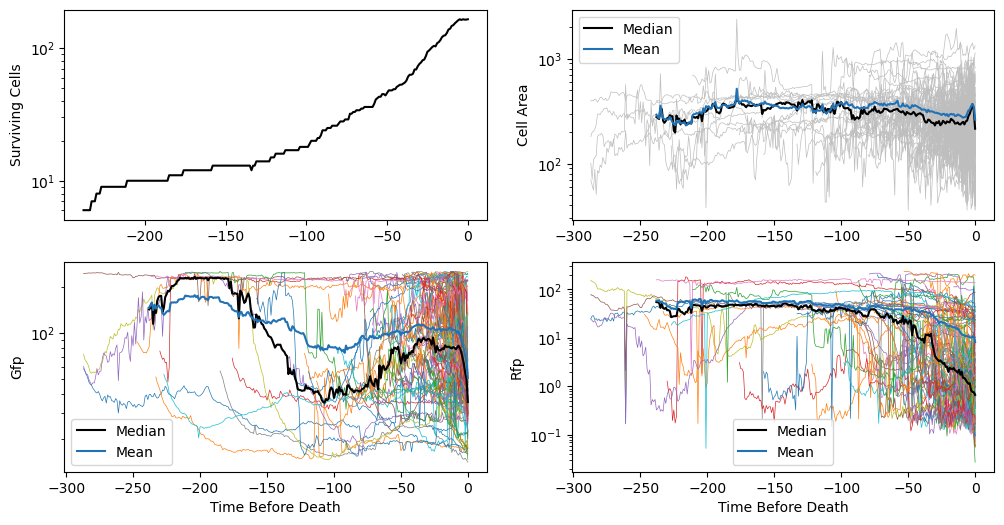

In [168]:
%matplotlib inline
fig, ax = plt.subplots(2,2, figsize=(12,6))
df=pd.read_csv('LysisDynamics.csv')
Narr=[]

#ax[0,0].plot(df.Frame.unique(),Narr)
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')

alldf=pd.DataFrame()
for cell in df.Cell.unique():
    dfcell=df[df.Cell==cell]
    if len(dfcell)>5:
        dff=pd.DataFrame({'Cell':[cell]*len(dfcell),'Time':-np.max(dfcell.Frame)+dfcell.Frame,
                         'Area':dfcell.Area,'Gfp':dfcell.Gfp,'Rfp':dfcell.Rfp})
        ax[0,1].plot(-np.max(dfcell.Frame)+dfcell.Frame,dfcell.Area,c='#bebebe',lw=0.5)
        ax[1,0].plot(-np.max(dfcell.Frame)+dfcell.Frame,dfcell.Gfp,lw=0.5)
        ax[1,1].plot(-np.max(dfcell.Frame)+dfcell.Frame,dfcell.Rfp,lw=0.5)
        alldf=pd.concat([alldf,dff])

data=[]
for time in np.sort(alldf.Time.unique()):
    dftime=alldf[alldf.Time==time]
    if len(dftime)>5:
        data.append([time,np.median(dftime.Area),np.median(dftime.Gfp),np.median(dftime.Rfp),len(dftime)])
dfff=pd.DataFrame(data,columns=['Time','Area','Gfp','Rfp','N'])
ax[0,1].plot(dfff.Time,dfff.Area,c='k',label='Median')
ax[1,0].plot(dfff.Time,dfff.Gfp,c='k',label='Median')
ax[1,1].plot(dfff.Time,dfff.Rfp,c='k',label='Median')
ax[0,0].plot(dfff.Time,dfff.N,c='k')

data=[]
for time in np.sort(alldf.Time.unique()):
    dftime=alldf[alldf.Time==time]
    if len(dftime)>5:
        data.append([time,np.mean(dftime.Area),np.mean(dftime.Gfp),np.mean(dftime.Rfp)])
dfff=pd.DataFrame(data,columns=['Time','Area','Gfp','Rfp'])
ax[0,1].plot(dfff.Time,dfff.Area,c='#2172B5',label='Mean')
ax[1,0].plot(dfff.Time,dfff.Gfp,c='#2172B5',label='Mean')
ax[1,1].plot(dfff.Time,dfff.Rfp,c='#2172B5',label='Mean')
    #plt.scatter(dfcell.Gfp/np.mean(dfcell.Gfp.tolist()),dfcell.Rfp/np.mean(dfcell.Rfp.tolist()),s=2)

ax[0,1].legend()
ax[1,1].legend()
ax[1,0].legend()

ax[0,0].set_ylabel('Surviving Cells')
ax[0,1].set_ylabel('Cell Area')
ax[1,0].set_ylabel('Gfp')
ax[1,1].set_ylabel('Rfp')

ax[1,1].set_xlabel('Time Before Death')
ax[1,0].set_xlabel('Time Before Death')

Text(0.5, 0, 'Time')

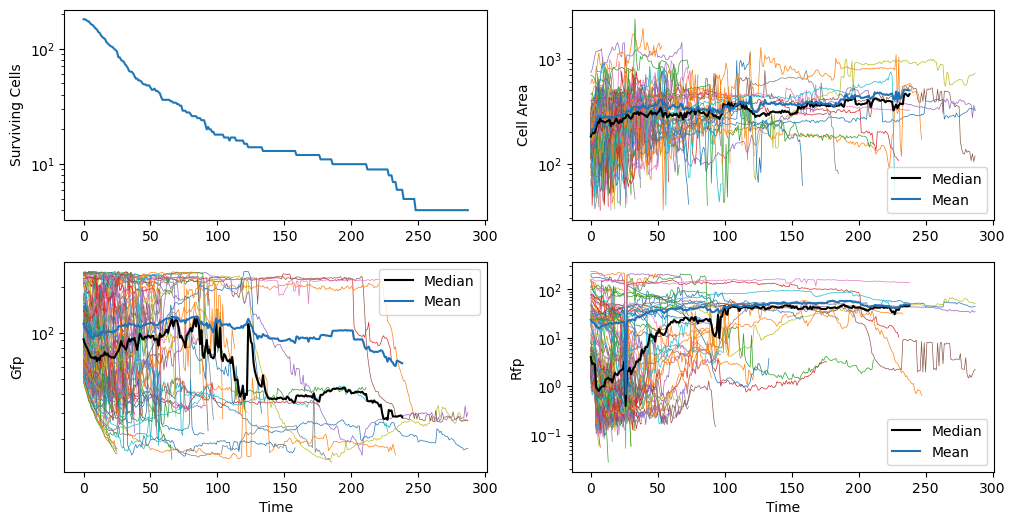

In [169]:
%matplotlib inline
fig, ax = plt.subplots(2,2, figsize=(12,6))
df=pd.read_csv('LysisDynamics.csv')
Narr=[]
for time in df.Frame.unique():
    dftime=df[df.Frame==time]
    N=len(dftime)
    Narr.append(N)
ax[0,0].plot(df.Frame.unique(),Narr)
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,1].set_yscale('log')
ax[1,0].set_yscale('log')

alldf=pd.DataFrame()
for cell in df.Cell.unique():
    dfcell=df[df.Cell==cell]
    if len(dfcell)>5:
        dff=pd.DataFrame({'Cell':[cell]*len(dfcell),'Time':dfcell.Frame,
                         'Area':dfcell.Area,'Gfp':dfcell.Gfp,'Rfp':dfcell.Rfp})
        ax[0,1].plot(dfcell.Frame,dfcell.Area,lw=0.5)
        ax[1,0].plot(dfcell.Frame,dfcell.Gfp,lw=0.5)
        ax[1,1].plot(dfcell.Frame,dfcell.Rfp,lw=0.5)
        alldf=pd.concat([alldf,dff])

data=[]
for time in np.sort(alldf.Time.unique()):
    dftime=alldf[alldf.Time==time]
    if len(dftime)>5:
        data.append([time,np.median(dftime.Area),np.median(dftime.Gfp),np.median(dftime.Rfp),len(dftime)])
dfff=pd.DataFrame(data,columns=['Time','Area','Gfp','Rfp','N'])
ax[0,1].plot(dfff.Time,dfff.Area,c='k',label='Median')
ax[1,0].plot(dfff.Time,dfff.Gfp,c='k',label='Median')
ax[1,1].plot(dfff.Time,dfff.Rfp,c='k',label='Median')
#ax[0,0].plot(dfff.Time,dfff.N,c='k')

data=[]
for time in np.sort(alldf.Time.unique()):
    dftime=alldf[alldf.Time==time]
    if len(dftime)>5:
        data.append([time,np.mean(dftime.Area),np.mean(dftime.Gfp),np.mean(dftime.Rfp)])
dfff=pd.DataFrame(data,columns=['Time','Area','Gfp','Rfp'])
ax[0,1].plot(dfff.Time,dfff.Area,c='#2172B5',label='Mean')
ax[1,0].plot(dfff.Time,dfff.Gfp,c='#2172B5',label='Mean')
ax[1,1].plot(dfff.Time,dfff.Rfp,c='#2172B5',label='Mean')
    #plt.scatter(dfcell.Gfp/np.mean(dfcell.Gfp.tolist()),dfcell.Rfp/np.mean(dfcell.Rfp.tolist()),s=2)

ax[0,1].legend()
ax[1,1].legend()
ax[1,0].legend()

ax[0,0].set_ylabel('Surviving Cells')
ax[0,1].set_ylabel('Cell Area')
ax[1,0].set_ylabel('Gfp')
ax[1,1].set_ylabel('Rfp')

ax[1,1].set_xlabel('Time')
ax[1,0].set_xlabel('Time')

Text(0.5, 0, 'Time Before Death')

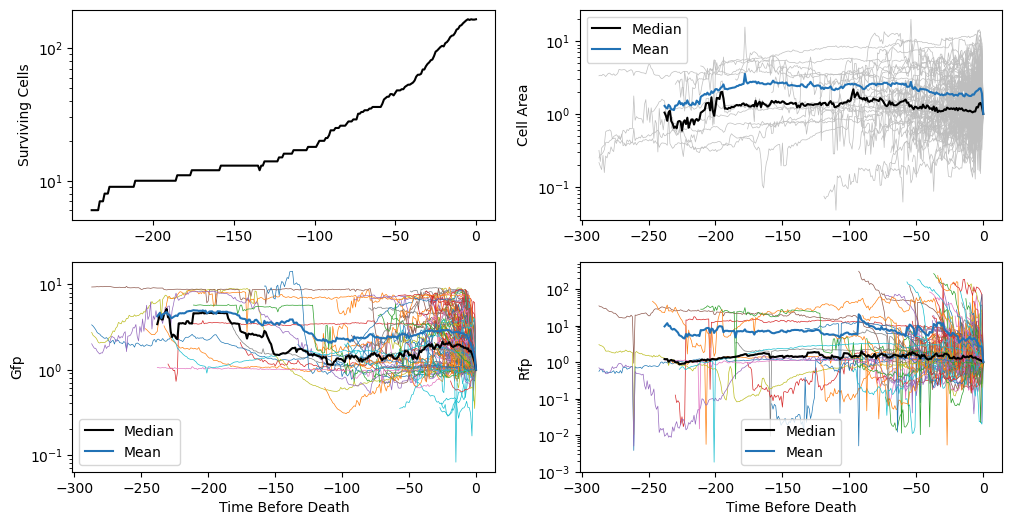

In [178]:
%matplotlib inline
fig, ax = plt.subplots(2,2, figsize=(12,6))
df=pd.read_csv('LysisDynamics.csv')
Narr=[]

#ax[0,0].plot(df.Frame.unique(),Narr)
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')

alldf=pd.DataFrame()
for cell in df.Cell.unique():
    dfcell=df[df.Cell==cell]
    if len(dfcell)>5:
        dff=pd.DataFrame({'Cell':[cell]*len(dfcell),'Time':-np.max(dfcell.Frame)+dfcell.Frame,
                         'Area':dfcell.Area/dfcell.Area.tolist()[-1],
                          'Gfp':dfcell.Gfp/dfcell.Gfp.tolist()[-1],
                          'Rfp':dfcell.Rfp/dfcell.Rfp.tolist()[-1]})
        ax[0,1].plot(-np.max(dfcell.Frame)+dfcell.Frame,dfcell.Area/dfcell.Area.tolist()[-1],c='#bebebe',lw=0.5)
        ax[1,0].plot(-np.max(dfcell.Frame)+dfcell.Frame,dfcell.Gfp/dfcell.Gfp.tolist()[-1],lw=0.5)
        ax[1,1].plot(-np.max(dfcell.Frame)+dfcell.Frame,dfcell.Rfp/dfcell.Rfp.tolist()[-1],lw=0.5)
        alldf=pd.concat([alldf,dff])

data=[]
for time in np.sort(alldf.Time.unique()):
    dftime=alldf[alldf.Time==time]
    if len(dftime)>5:
        data.append([time,np.median(dftime.Area),np.median(dftime.Gfp),np.median(dftime.Rfp),len(dftime)])
dfff=pd.DataFrame(data,columns=['Time','Area','Gfp','Rfp','N'])
ax[0,1].plot(dfff.Time,dfff.Area,c='k',label='Median')
ax[1,0].plot(dfff.Time,dfff.Gfp,c='k',label='Median')
ax[1,1].plot(dfff.Time,dfff.Rfp,c='k',label='Median')
ax[0,0].plot(dfff.Time,dfff.N,c='k')

data=[]
for time in np.sort(alldf.Time.unique()):
    dftime=alldf[alldf.Time==time]
    if len(dftime)>5:
        data.append([time,np.mean(dftime.Area),np.mean(dftime.Gfp),np.mean(dftime.Rfp)])
dfff=pd.DataFrame(data,columns=['Time','Area','Gfp','Rfp'])
ax[0,1].plot(dfff.Time,dfff.Area,c='#2172B5',label='Mean')
ax[1,0].plot(dfff.Time,dfff.Gfp,c='#2172B5',label='Mean')
ax[1,1].plot(dfff.Time,dfff.Rfp,c='#2172B5',label='Mean')
    #plt.scatter(dfcell.Gfp/np.mean(dfcell.Gfp.tolist()),dfcell.Rfp/np.mean(dfcell.Rfp.tolist()),s=2)

ax[0,1].legend()
ax[1,1].legend()
ax[1,0].legend()

ax[0,0].set_ylabel('Surviving Cells')
ax[0,1].set_ylabel('Cell Area')
ax[1,0].set_ylabel('Gfp')
ax[1,1].set_ylabel('Rfp')

ax[1,1].set_xlabel('Time Before Death')
ax[1,0].set_xlabel('Time Before Death')

Text(0.5, 0, 'Time')

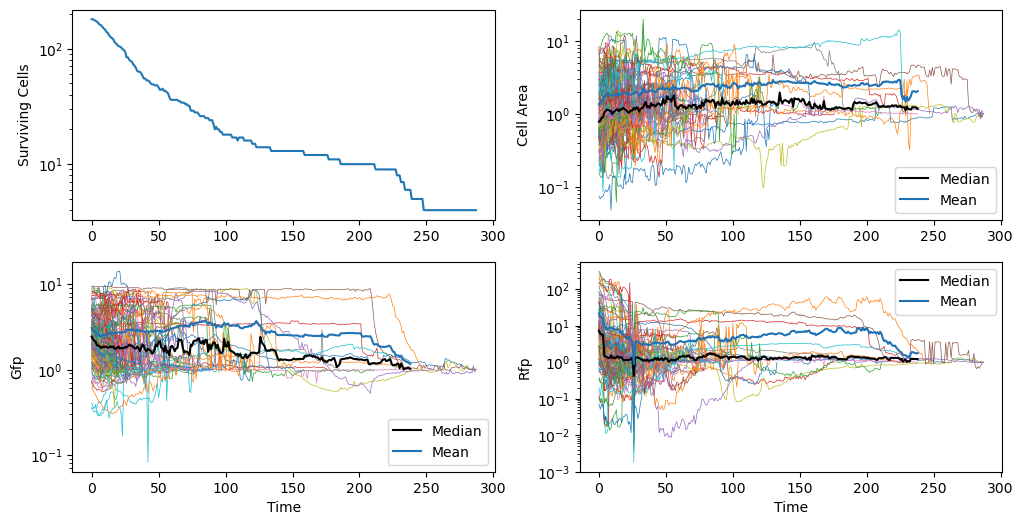

In [179]:
%matplotlib inline
fig, ax = plt.subplots(2,2, figsize=(12,6))
df=pd.read_csv('LysisDynamics.csv')
Narr=[]
for time in df.Frame.unique():
    dftime=df[df.Frame==time]
    N=len(dftime)
    Narr.append(N)
ax[0,0].plot(df.Frame.unique(),Narr)
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,1].set_yscale('log')
ax[1,0].set_yscale('log')

alldf=pd.DataFrame()
for cell in df.Cell.unique():
    dfcell=df[df.Cell==cell]
    if len(dfcell)>5:
        dff=pd.DataFrame({'Cell':[cell]*len(dfcell),'Time':dfcell.Frame,
                         'Area':dfcell.Area/dfcell.Area.tolist()[-1]
                          ,'Gfp':dfcell.Gfp/dfcell.Gfp.tolist()[-1],
                          'Rfp':dfcell.Rfp/dfcell.Rfp.tolist()[-1]})
        ax[0,1].plot(dfcell.Frame,dfcell.Area/dfcell.Area.tolist()[-1],lw=0.5)
        ax[1,0].plot(dfcell.Frame,dfcell.Gfp/dfcell.Gfp.tolist()[-1],lw=0.5)
        ax[1,1].plot(dfcell.Frame,dfcell.Rfp/dfcell.Rfp.tolist()[-1],lw=0.5)
        alldf=pd.concat([alldf,dff])

data=[]
for time in np.sort(alldf.Time.unique()):
    dftime=alldf[alldf.Time==time]
    if len(dftime)>5:
        data.append([time,np.median(dftime.Area),np.median(dftime.Gfp),np.median(dftime.Rfp),len(dftime)])
dfff=pd.DataFrame(data,columns=['Time','Area','Gfp','Rfp','N'])
ax[0,1].plot(dfff.Time,dfff.Area,c='k',label='Median')
ax[1,0].plot(dfff.Time,dfff.Gfp,c='k',label='Median')
ax[1,1].plot(dfff.Time,dfff.Rfp,c='k',label='Median')
#ax[0,0].plot(dfff.Time,dfff.N,c='k')

data=[]
for time in np.sort(alldf.Time.unique()):
    dftime=alldf[alldf.Time==time]
    if len(dftime)>5:
        data.append([time,np.mean(dftime.Area),np.mean(dftime.Gfp),np.mean(dftime.Rfp)])
dfff=pd.DataFrame(data,columns=['Time','Area','Gfp','Rfp'])
ax[0,1].plot(dfff.Time,dfff.Area,c='#2172B5',label='Mean')
ax[1,0].plot(dfff.Time,dfff.Gfp,c='#2172B5',label='Mean')
ax[1,1].plot(dfff.Time,dfff.Rfp,c='#2172B5',label='Mean')
    #plt.scatter(dfcell.Gfp/np.mean(dfcell.Gfp.tolist()),dfcell.Rfp/np.mean(dfcell.Rfp.tolist()),s=2)

ax[0,1].legend()
ax[1,1].legend()
ax[1,0].legend()

ax[0,0].set_ylabel('Surviving Cells')
ax[0,1].set_ylabel('Cell Area')
ax[1,0].set_ylabel('Gfp')
ax[1,1].set_ylabel('Rfp')

ax[1,1].set_xlabel('Time')
ax[1,0].set_xlabel('Time')

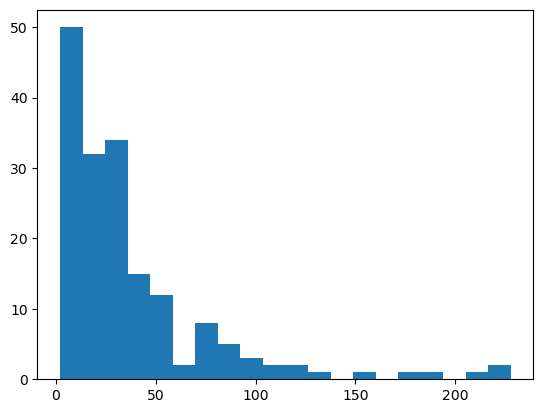

In [3]:
%matplotlib inline
#fig, ax = plt.subplots(2,2, figsize=(12,6))
df=pd.read_csv('LysisDynamics.csv')


lives=[]
for cell in df.Cell.unique():
    dfcell=df[df.Cell==cell]
    if len(dfcell)<230:
        lives.append(len(dfcell))
plt.hist(lives,bins=20);